In [35]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import distance
import re

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix, recall_score, precision_score, classification_report

from ingeniring_utils import * # import all existing functions from file cleaning.py
from modeling_utils import *

%load_ext autoreload
%autoreload 2


pd.set_option('display.max_columns', 360)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Loading Data

df = pd.read_csv('data/df.csv')

In [4]:
df.columns

Index(['ticket_id', 'agency_name', 'disposition', 'discount_amount',
       'judgment_amount', 'compliance', 'lon', 'lat', 'parcel_id', 'AddCombo',
       'Structure', 'Condition', 'Occupancy', 'Needs_Boarding', 'Fire',
       'Dumping', 'Units', 'coordinates', 'crime_count'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78823 entries, 0 to 78822
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ticket_id        78823 non-null  int64  
 1   agency_name      78823 non-null  object 
 2   disposition      78823 non-null  object 
 3   discount_amount  78823 non-null  float64
 4   judgment_amount  78823 non-null  float64
 5   compliance       78823 non-null  float64
 6   lon              78823 non-null  float64
 7   lat              78823 non-null  float64
 8   parcel_id        78823 non-null  int64  
 9   AddCombo         78823 non-null  object 
 10  Structure        78823 non-null  object 
 11  Condition        78823 non-null  object 
 12  Occupancy        78823 non-null  object 
 13  Needs_Boarding   78823 non-null  object 
 14  Fire             78823 non-null  object 
 15  Dumping          78823 non-null  object 
 16  Units            78823 non-null  object 
 17  coordinates 

In [6]:
# define target variable and categorical features

target = df['compliance']

features = ['agency_name', 'disposition', 'discount_amount',
            'judgment_amount', 'Structure', 'Condition', 'Occupancy',
            'Needs_Boarding', 'Fire', 'Dumping', 'Units', 'crime_count']

numeric_features = ['discount_amount', 'judgment_amount', 'crime_count']

cat_features = ['agency_name', 'disposition', 'Structure', 'Condition', 
                 'Occupancy', 'Needs_Boarding', 'Fire', 'Dumping', 'Units']

In [7]:
numeric_var_analysis(df, numeric_features)

Continuous Variables
                   count        mean         std  min    25%    50%    75%  \
discount_amount  78823.0    0.190744    3.967237  0.0    0.0    0.0    0.0   
judgment_amount  78823.0  398.172263  698.438851  0.0  167.5  305.0  305.0   
crime_count      78823.0    1.284815    1.097467  0.0    1.0    1.0    2.0   

                     max  
discount_amount    350.0  
judgment_amount  11030.0  
crime_count          9.0  


In [8]:
categor_var_analysis(df, cat_features)

Discrete Variables
agency_name
Buildings, Safety Engineering & Env Department    46979
Department of Public Works                        26124
Detroit Police Department                          2230
Health Department                                  3490
Name: agency_name, dtype: int64
--------------------------------------------------------------------------------
disposition
Responsible (Fine Waived) by Deter       93
Responsible by Admission               7035
Responsible by Default                67913
Responsible by Determination           3782
Name: disposition, dtype: int64
--------------------------------------------------------------------------------
Structure
no         4
yes    78819
Name: Structure, dtype: int64
--------------------------------------------------------------------------------
Condition
fair                  15898
good                  54535
poor                   5773
suggest demolition     2617
Name: Condition, dtype: int64
--------------------------------

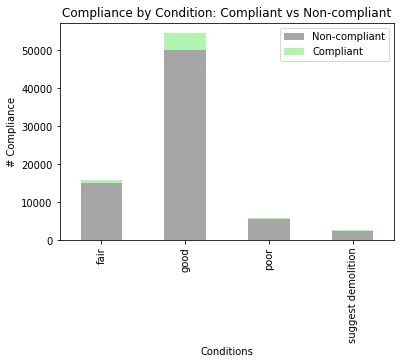

In [9]:
# Condition class visualization

condition = df.groupby(['Condition','compliance']).Condition.count().unstack()
p1 = condition.plot(kind = 'bar', stacked = True, 
                   title = 'Compliance by Condition: Compliant vs Non-compliant', 
                   color = ['grey','lightgreen'], alpha = .70)

p1.set_xlabel('Conditions')
p1.set_ylabel('# Compliance')
p1.legend(['Non-compliant','Compliant'])
plt.show()

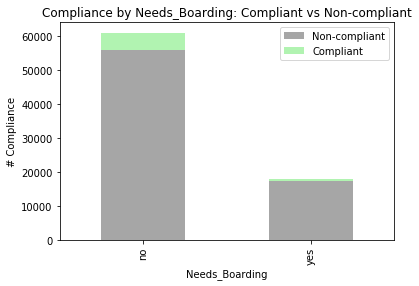

In [10]:
# Needs_Boarding class visualization

Needs_Boarding = df.groupby(['Needs_Boarding','compliance']).Needs_Boarding.count().unstack()
p1 = Needs_Boarding.plot(kind = 'bar', stacked = True, 
                   title = 'Compliance by Needs_Boarding: Compliant vs Non-compliant', 
                   color = ['grey','lightgreen'], alpha = .70)

p1.set_xlabel('Needs_Boarding')
p1.set_ylabel('# Compliance')
p1.legend(['Non-compliant','Compliant'])
plt.show()

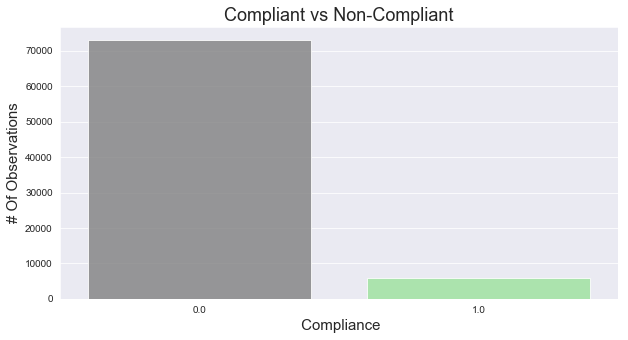

In [11]:
# Target Variable Countplot
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(target, alpha =.80, palette= ['grey','lightgreen'])
plt.title('Compliant vs Non-Compliant', size = 18)
plt.ylabel('# Of Observations', size =15)
plt.xlabel(' Compliance', size =15)
plt.show()

In [12]:
#  Creating dummy variables for categorical variables wit function to_dummies.
X = to_dummies(df[features], cat_features)
y = target

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78823 entries, 0 to 78822
Data columns (total 21 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   discount_amount                           78823 non-null  float64
 1   judgment_amount                           78823 non-null  float64
 2   crime_count                               78823 non-null  int64  
 3   agency_name_Department of Public Works    78823 non-null  uint8  
 4   agency_name_Detroit Police Department     78823 non-null  uint8  
 5   agency_name_Health Department             78823 non-null  uint8  
 6   disposition_Responsible by Admission      78823 non-null  uint8  
 7   disposition_Responsible by Default        78823 non-null  uint8  
 8   disposition_Responsible by Determination  78823 non-null  uint8  
 9   Structure_yes                             78823 non-null  uint8  
 10  Condition_good                    

-----

## Logistic Regression Model 

AUC: 0.805328977424424


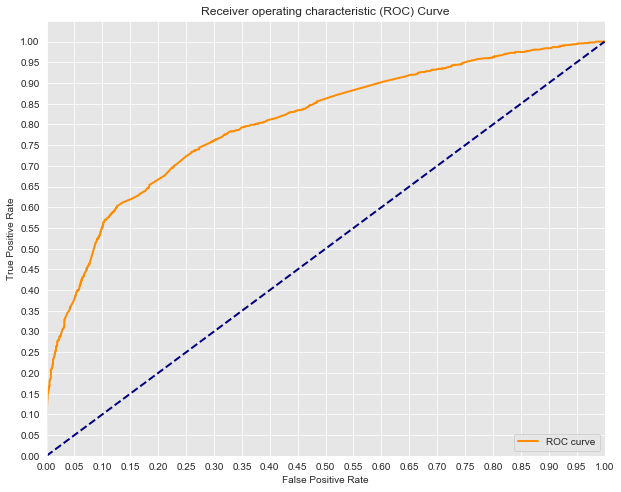



 Cofusion Matrix 




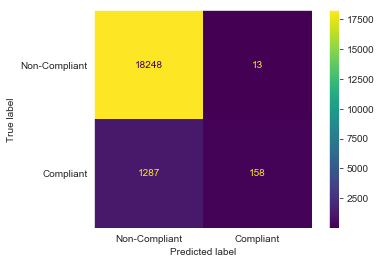


General Report 

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97     18261
         1.0       0.92      0.11      0.20      1445

    accuracy                           0.93     19706
   macro avg       0.93      0.55      0.58     19706
weighted avg       0.93      0.93      0.91     19706



In [36]:
log_reg(X, y, roc = True)

### Using SMOTE class from the imblearn package in order to improve the model's performance on the minority class.

In [37]:
# Previous original class distribution
print(y_train.value_counts()) 

# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 

# Note, if you get an Attribute Error: 'SMOTE' object has no attribute
# '_validate_data', then downgrade your version of imblearn to 0.6.2
# or upgrade your version of sklearn to 0.23

0.0    54793
1.0     4324
Name: compliance, dtype: int64


1.0    54793
0.0    54793
Name: compliance, dtype: int64


### Logistic Regression Model with SMOTE

LogisticRegression(C=0.005, fit_intercept=False, solver='liblinear')
AUC for 0.005: 0.7972826667728821
-------------------------------------------------------
LogisticRegression(C=0.1, fit_intercept=False, solver='liblinear')
AUC for 0.1: 0.7915021650322929
-------------------------------------------------------
LogisticRegression(C=0.2, fit_intercept=False, solver='liblinear')
AUC for 0.2: 0.7907249324959817
-------------------------------------------------------
LogisticRegression(C=0.5, fit_intercept=False, solver='liblinear')
AUC for 0.5: 0.7912077711612547
-------------------------------------------------------
LogisticRegression(C=0.8, fit_intercept=False, solver='liblinear')
AUC for 0.8: 0.7901574106547794
-------------------------------------------------------
LogisticRegression(C=1, fit_intercept=False, solver='liblinear')
AUC for 1: 0.7902698460215627
-------------------------------------------------------
LogisticRegression(C=1.25, fit_intercept=False, solver='liblinear')
AU

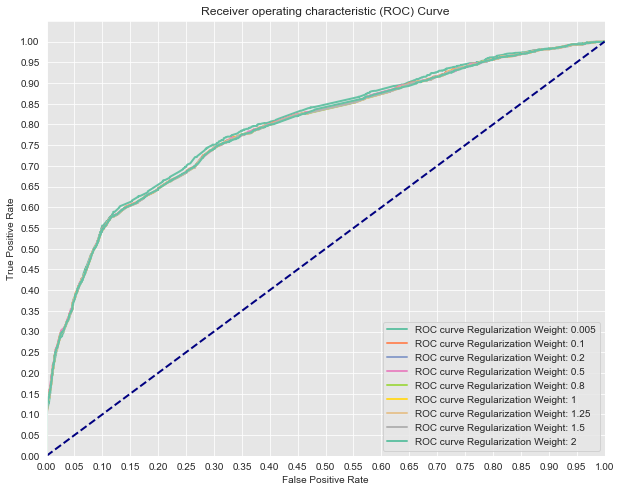

In [38]:
# Now let's compare a few different regularization performances on the dataset
C_param_range = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
names = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Descision Tree Model

Feature Importance: 



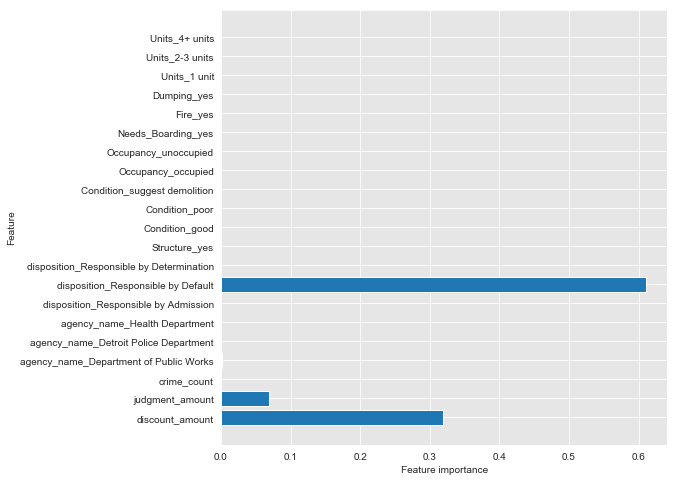

Confusion Matrix: 

[[18277     6]
 [ 1260   163]]

General Report 

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     18283
         1.0       0.96      0.11      0.20      1423

    accuracy                           0.94     19706
   macro avg       0.95      0.56      0.59     19706
weighted avg       0.94      0.94      0.91     19706

Testing Accuracy for Decision Tree Classifier: 93.58%


In [39]:
decision_tree(X, y, max_depth = 10)

----

### Descision Tree Model with SMOTE

Feature Importance: 



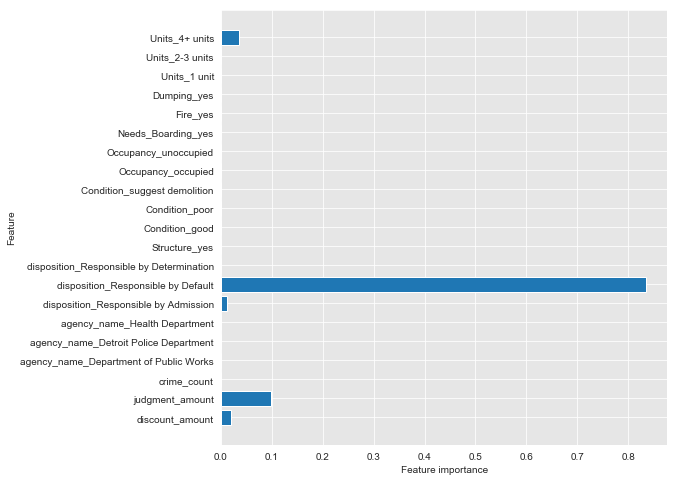

Confusion Matrix: 

[[16372  1911]
 [  627   796]]

General Report 

              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93     18283
         1.0       0.29      0.56      0.39      1423

    accuracy                           0.87     19706
   macro avg       0.63      0.73      0.66     19706
weighted avg       0.91      0.87      0.89     19706

Testing Accuracy for Decision Tree Classifier: 87.12%


In [40]:
decision_tree_smote(X, y , max_depth=3)

## Usinng Cross Validation

In [41]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(ctree, X, y, cv = 10)
score.mean()
depth_range = range(1,10)
val = []
for depth in depth_range:
    ctree = DecisionTreeClassifier(max_depth = depth)
    depth_score = cross_val_score(ctree, X, y, cv = 10)
    val.append(depth_score.mean())
print(val)
plt.figure(figsize = (10,10))
plt.plot(depth_range, val)
plt.xlabel('range of depth')
plt.ylabel('cross validated values')
plt.show()

NameError: name 'ctree' is not defined